# Mechanistic Interpretability applications

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path

# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")

# from scipy.stats import wilcoxon

# from timm import create_model
import torch

# from src.accuracy import compute_accuracy
# from src.datasets.imagenet import ImagenetDatasetS
# from src.identifiability import get_class_embed
# from src.memories import Memory
# from src.vis import Vis

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

__TO-DO__: Define your path to the project folder and ImageNet-S dataset here:

In [4]:
PROJ_PATH = []
DATASET_PATH =  []
CIFAR_PATH = []

In [5]:
PROJ_PATH = "/Users/m_vilas/projects/vit-cls-emb"
DATASET_PATH =  "/Users/m_vilas/datasets/visual/ImageNet-S/"
CIFAR_PATH = "/Users/m_vilas/datasets/visual/cifar100/"

In [6]:
# Define paths
PROJ_PATH = Path(PROJ_PATH)
DATASET_PATH = Path(DATASET_PATH)
CIFAR_PATH = Path(CIFAR_PATH)
RES_PATH = PROJ_PATH / 'results'

In [7]:
# Get dataset info
from src.datasets.imagenet import ImagenetDatasetS

dataset = ImagenetDatasetS(DATASET_PATH)
stim_info = dataset.stim_info

In [8]:
MODEL_MAP = {
    'vit_b_32': 'ViT-B/32',
    'vit_b_16': 'ViT-B/16',
    'vit_large_16': 'ViT-L/16',
    'vit_miil_16': 'ViT-B/16-MIIL',
    'vit_cifar_16': 'ViT-B/16-CIFAR',
    'deit_ensemble_16': 'ViT-B/16-Refinement',
    'vit_gap_16': 'ViT-B/16-GAP',
}

## Building categorical representations

To investigate the extent to which self-attention and MLP layers help build categorical representations, we measure the __class similarity change rate__ induced by these sub-modules.
Given a layer with input/output tokens and a class embedding matrix, we compute the proportion of output tokens whose correct class logits increase relative to the corresponding logits for input tokens, where all logits are obtained by projecting the tokens using the class embedding matrix.

Concretely, we projected the output of each layer $\mathbf{O}^{l}(\mathbf{X})$ to the class embedding space by $\mathbf{p}_{\text{out}}  = \mathbf{E} \cdot \mathbf{O}^l(\mathbf{X})^T$, and compared it to the projection of the input itself $\mathbf{p}_{\text{inp}} =\mathbf{E} \cdot \mathbf{X}^T$. 
We then compute the proportion of tokens $i$ where $p^i_{\text{out}} > p^i_{\text{inp}}$.

In [9]:
from src.plots.mech_interp import plot_class_building

#### ViT-B/32

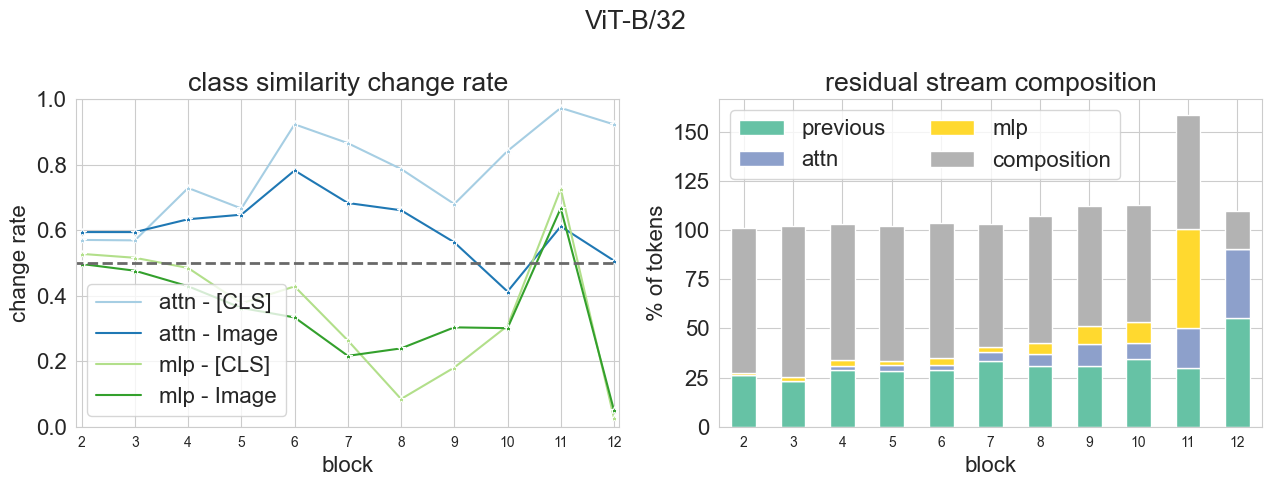

In [10]:
plot_class_building('vit_b_32', RES_PATH, DATASET_PATH)

#### ViT-B/16

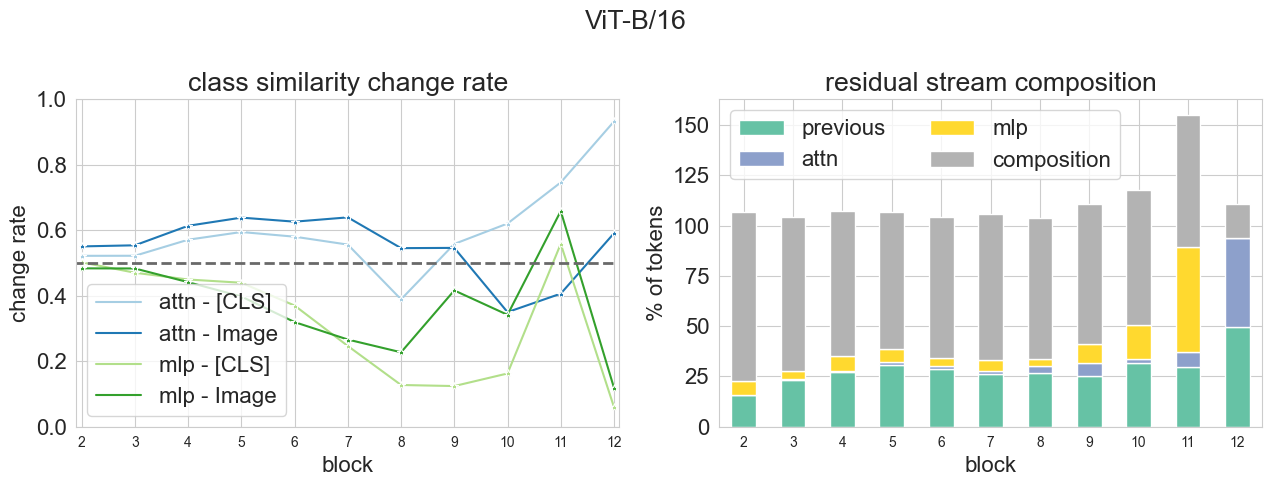

In [15]:
plot_class_building('vit_b_16', RES_PATH, DATASET_PATH)

#### ViT-L/16

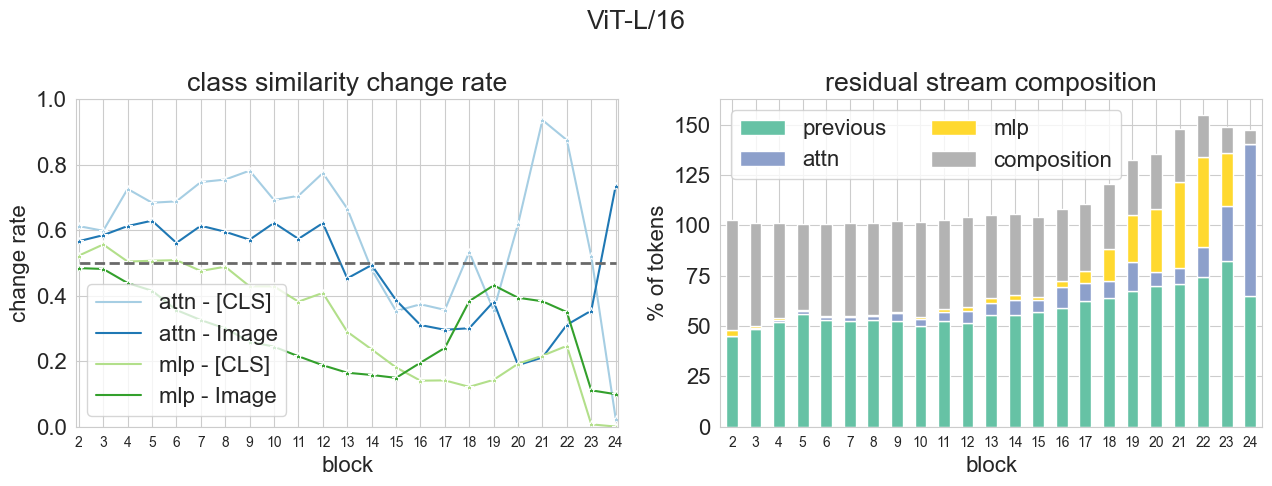

In [16]:
plot_class_building('vit_large_16', RES_PATH, DATASET_PATH)

#### ViT-B/16 - MILL

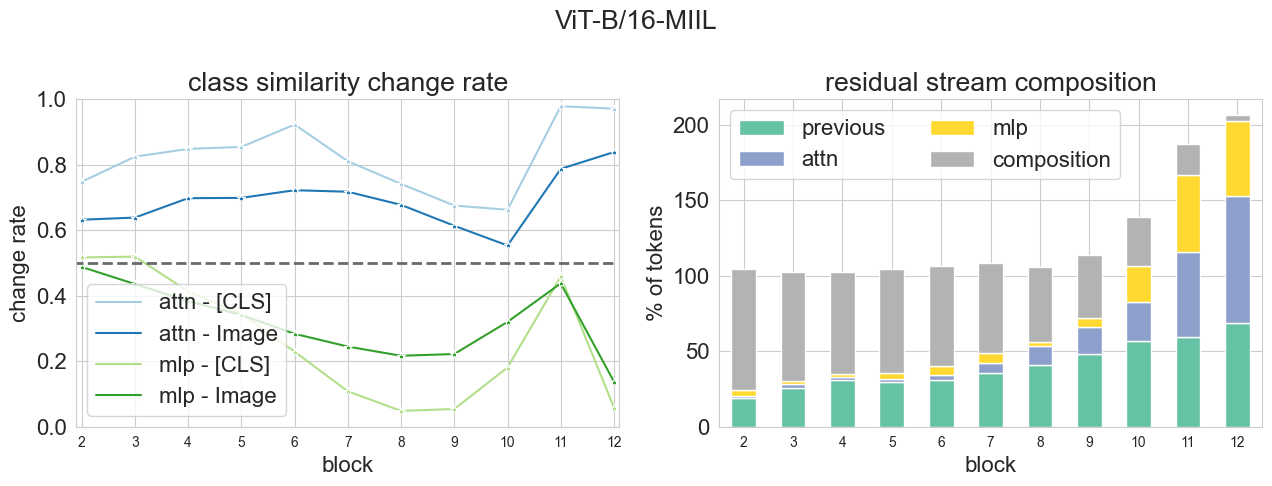

In [18]:
plot_class_building('vit_miil_16', RES_PATH, DATASET_PATH)

#### ViT-B/16 - CIFAR

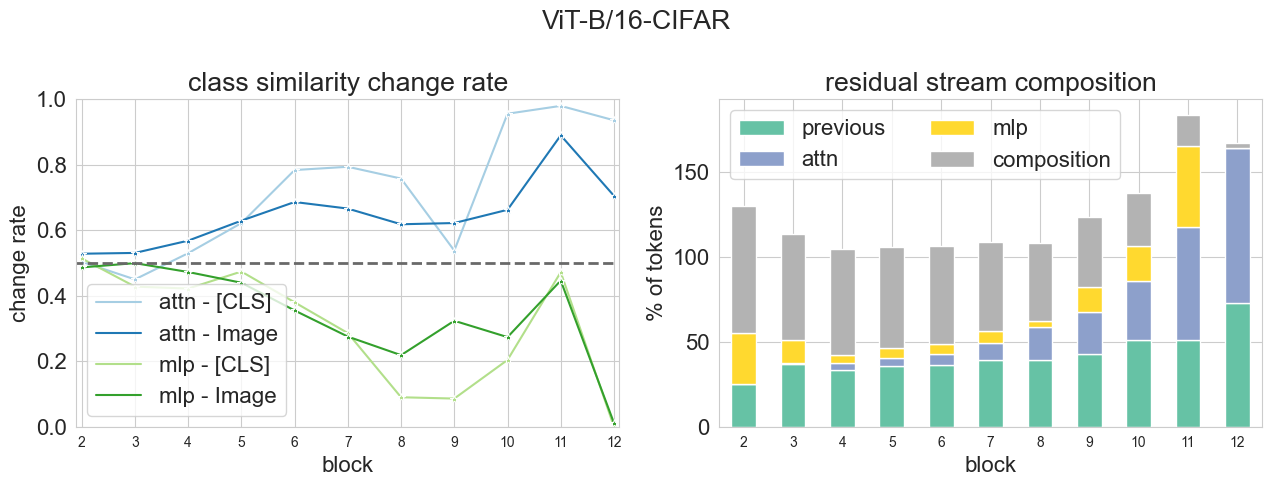

In [19]:
plot_class_building('vit_cifar_16', RES_PATH, CIFAR_PATH)

#### ViT-B/16 - Refinement

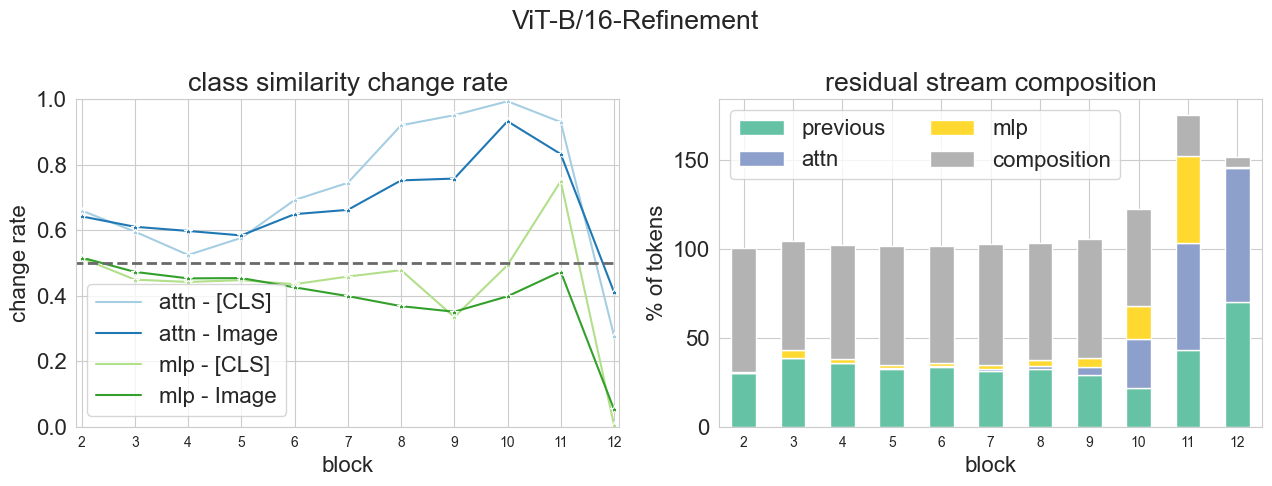

In [21]:
plot_class_building('deit_ensemble_16', RES_PATH, DATASET_PATH)

#### ViT-B/16 - GAP

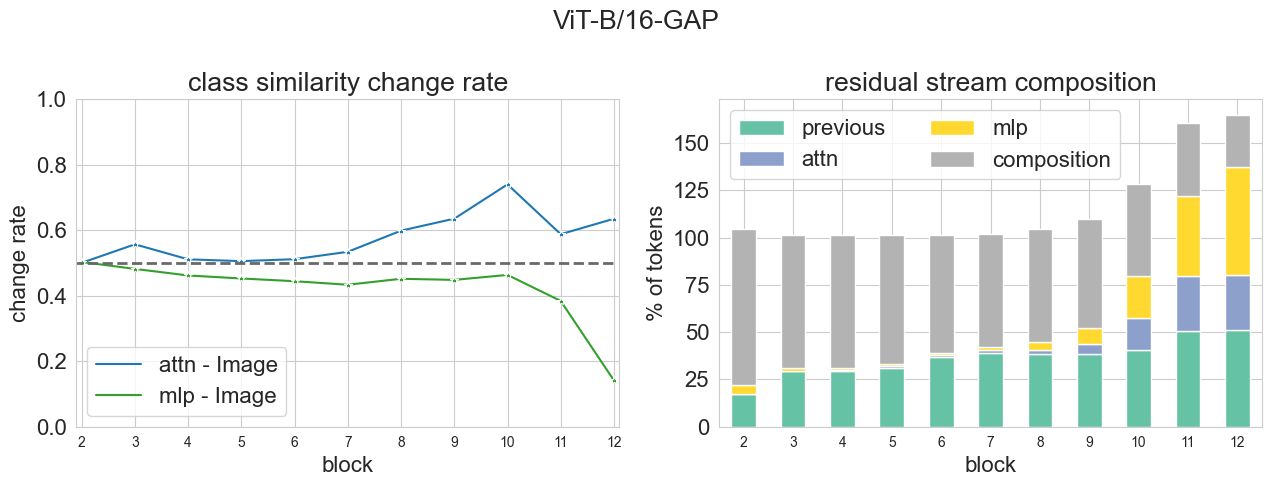

In [22]:
plot_class_building('vit_gap_16', RES_PATH, DATASET_PATH)

### Difference in class similarity change rate between class and context-labeled tokens

We additionally compare the change rate of class- and context-labeled tokens in self-attention layers.

In [9]:
from src.plots.mech_interp import compute_context_diff

Change the `model` variable to print results for different ViT variants.

In [10]:
model = 'vit_b_32'

df = compute_context_diff(model, 'attn', PROJ_PATH, DATASET_PATH)
display(df)

,diffs,pvals,model,layer,block
0,0.007023,0.216667,vit_b_32,attn,0
1,0.029557,0.000000,vit_b_32,attn,1
2,0.127190,0.000000,vit_b_32,attn,2
3,0.215745,0.000000,vit_b_32,attn,3
4,0.231144,0.000000,vit_b_32,attn,4
5,0.232179,0.000000,vit_b_32,attn,5
6,0.343491,0.000000,vit_b_32,attn,6
7,0.435765,0.000000,vit_b_32,attn,7
8,-0.409439,1.000000,vit_b_32,attn,8
9,-0.563637,1.000000,vit_b_32,attn,9


## Categorical updates

To investigate how self-attention and MLP layers carry out categorical updates by promoting class-prototype representations, we project their output parameter matrices into the class-embedding space, by computing $\textbf{P}_{W_{\text{out}}} = \mathbf{E} \cdot \mathbf{W}^T_{\text{out}}$.
The rows of $ \mathbf{E}$ and $\mathbf{W}_{\text{out}}$ are normalized to unit length to enable comparison across ViT variants.

This projection measures the extent to which each row in the output parameter matrices reflects the classes encoded in the embedding space, and thus probes whether the value vectors of the key-value memory pair system have high correspondence with class prototype representations.

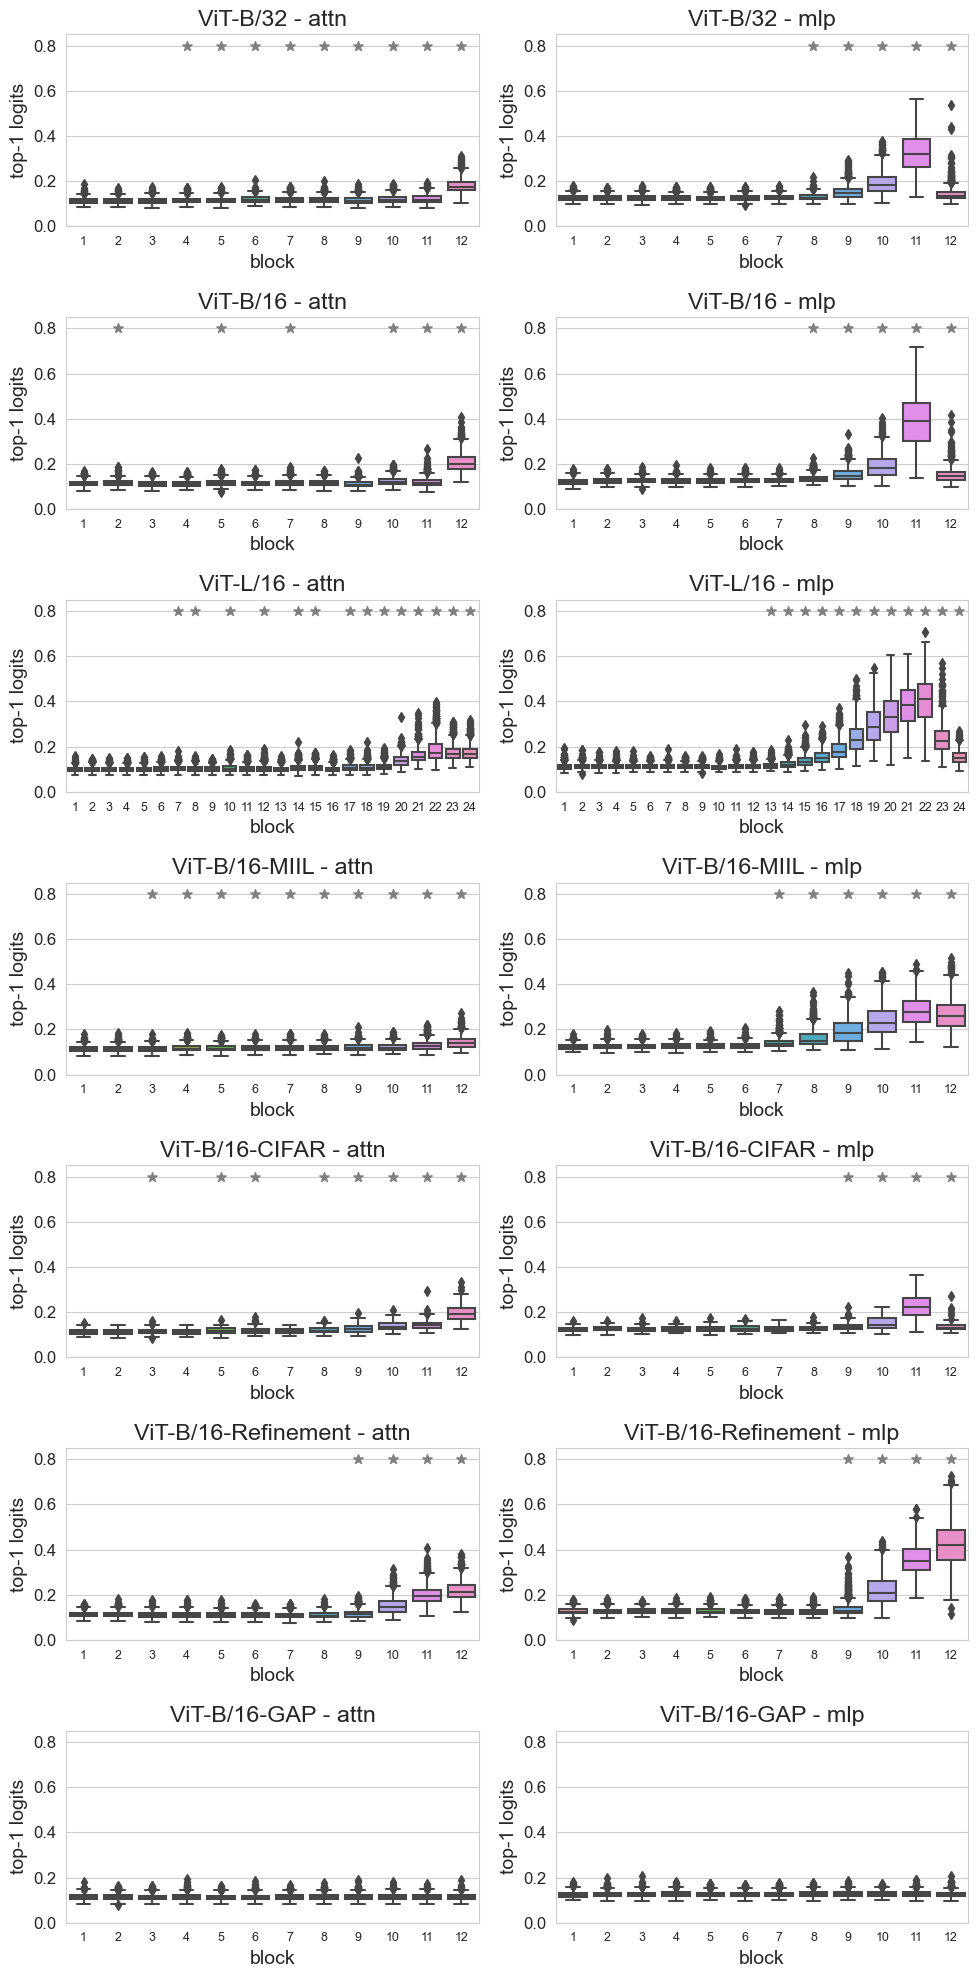

In [32]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(10, 20))
for m_idx, model in enumerate(MODEL_MAP.keys()):
    mem = Memory(PROJ_PATH, DATASET_PATH, model)
    
    for l_idx, layer_type in enumerate(['attn', 'mlp']):
        df, pvals_l, _ = mem.compute_class_value_agr(layer_type)
    
        # Plot pvalues
        sig = np.where(np.array(pvals_l) < 0.05)[0]
        axes[m_idx, l_idx].scatter(sig, [0.8] * len(sig), marker='*', c='grey', s=50)
    
        # Plot agreement values
        sns.boxplot(df, x='block', y='top-1 logits', ax=axes[m_idx, l_idx])
        axes[m_idx, l_idx].set_ylim((0,0.85))
        axes[m_idx, l_idx].xaxis.set_tick_params(labelsize=9)
        axes[m_idx, l_idx].yaxis.set_tick_params(labelsize=12)
        
        axes[m_idx, l_idx].set_title(f'{MODEL_MAP[model]} - {layer_type}')

plt.tight_layout()
f = RES_PATH / 'figures' / f'match_score.png'
plt.savefig(f, dpi=300)
plt.show()

### Human-interpretable value vectors

A manual inspection of the MLP layers containing high class-value agreement scores revealed that value vectors may promote and cluster semantically similar and human-interpretable concepts

#### ViT-B/32 and MLP layer 11

In [19]:
# Project classes onto values
model = create_model('vit_base_patch32_224', pretrained=True).to(device)
val_proj = model.head.weight @ model.blocks[10].mlp.fc2.weight

# Illustrate the classes with the highest dot product for some example value vectors
for k in [4, 8, 10, 32, 33, 35, 40]:
    print(f'Neuron {k}:')
    coeff_top_memories = val_proj[:, k].topk(5, dim=-1)
    for val, idx in zip(coeff_top_memories[0].detach().numpy(), coeff_top_memories[1].detach().numpy()):
        try:
            cat = dataset.stim_info.loc[dataset.stim_info["index"] == idx]["cat"].unique()[0]
            print(f'{cat}')
        except:
            continue # Ignore classes that are not in Imagenet-S
    print('\n')  

Neuron 4:
racket, racquet
tennis ball
ping-pong ball
volleyball
croquet ball


Neuron 8:
Arctic fox, white fox, Alopex lagopus
brown bear, bruin, Ursus arctos
wombat
American black bear, black bear, Ursus americanus, Euarctos americanus
wild boar, boar, Sus scrofa


Neuron 10:
agama
whiptail, whiptail lizard
alligator lizard
green lizard, Lacerta viridis
American chameleon, anole, Anolis carolinensis


Neuron 32:
groenendael
Scotch terrier, Scottish terrier, Scottie
Afghan hound, Afghan
flat-coated retriever
Newfoundland, Newfoundland dog


Neuron 33:
strawberry
pineapple, ananas
tray
banana


Neuron 35:
rifle
revolver, six-gun, six-shooter
assault rifle, assault gun
scabbard
holster


Neuron 40:
wolf spider, hunting spider
garden spider, Aranea diademata
barn spider, Araneus cavaticus
harvestman, daddy longlegs, Phalangium opilio
spider web, spider's web




#### ViT-B/16 and MLP layer 11

In [20]:
# Project classes onto values
model = create_model('vit_base_patch16_224', pretrained=True).to(device)
val_proj = model.head.weight @ model.blocks[10].mlp.fc2.weight

# Illustrate the classes with the highest dot product for some example value vectors
for k in [2, 7, 14, 18, 21, 24, 26]:
    print(f'Neuron {k}:')
    coeff_top_memories = val_proj[:, k].topk(5, dim=-1)
    for val, idx in zip(coeff_top_memories[0].detach().numpy(), coeff_top_memories[1].detach().numpy()):
        try:
            cat = dataset.stim_info.loc[dataset.stim_info["index"] == idx]["cat"].unique()[0]
            print(f'{cat}')
        except:
            continue
    print('\n')  

Neuron 2:
boathouse
paddle, boat paddle
water buffalo, water ox, Asiatic buffalo, Bubalus bubalis
gondola


Neuron 7:
microphone, mike
radio, wireless
electric guitar
loudspeaker, speaker, speaker unit, loudspeaker system, speaker system


Neuron 14:
screwdriver
carpenter's kit, tool kit
plane, carpenter's plane, woodworking plane
power drill
shovel


Neuron 18:
collie
Border collie
kelpie
kuvasz
Eskimo dog, husky


Neuron 21:
guinea pig, Cavia cobaya
beaver
hare
hamster
catamaran


Neuron 24:
rifle
assault rifle, assault gun
revolver, six-gun, six-shooter
bow
holster


Neuron 26:
drum, membranophone, tympan
maraca
chime, bell, gong
steel drum
drumstick




## Key-value memory pairs at inference time

To investigate if self-attention and MLP layers act as key-value memory pair systems at inference time, we measured how the keys that are most activated during the processing of a sample, correspond to the value vectors that promote the representation of the correct class.

Concretely, for each layer, we quantified the proportion of tokens where the 5 keys with the highest coefficients are associated with value vectors whose top-5 logits (obtained by the projection $\mathbf{E} \cdot \mathbf{W}_{\text{out}}$) index the correct class.
We call this metric _key-value agreement rate_.

In [21]:
def compute_key_value_agr_rate(model_name, layer_type, random=False, tokens='all'):
    """
    Compute key-value agreement rate.
    """
    if 'large' in model_name:
        n_layers = 24
    else:
        n_layers = 12
    
    agreement_rate = []
    for b in range(n_layers):
        f = RES_PATH / 'memories/' / model_name / f'{layer_type}_{b}_value-class_agreement.pt'
        agr = torch.load(f, map_location='cpu')
        if tokens == 'all':
            agr = agr.flatten(start_dim=1)
        elif tokens == 'cls':
            agr = agr[:,:, 0]
        tokens_agr = torch.sum(agr, dim=1) / agr.shape[1] * 100
        agreement_rate.append(tokens_agr)

    agreement_rate = torch.stack(agreement_rate).flatten().detach().numpy()
    agreement_rate = pd.DataFrame(
        {'block': torch.arange(1,n_layers+1).repeat_interleave(agr.shape[0]), 'agreement rate': agreement_rate}
    )
    agreement_rate['agreement rate'] = agreement_rate['agreement rate'].astype('float')
    return agreement_rate

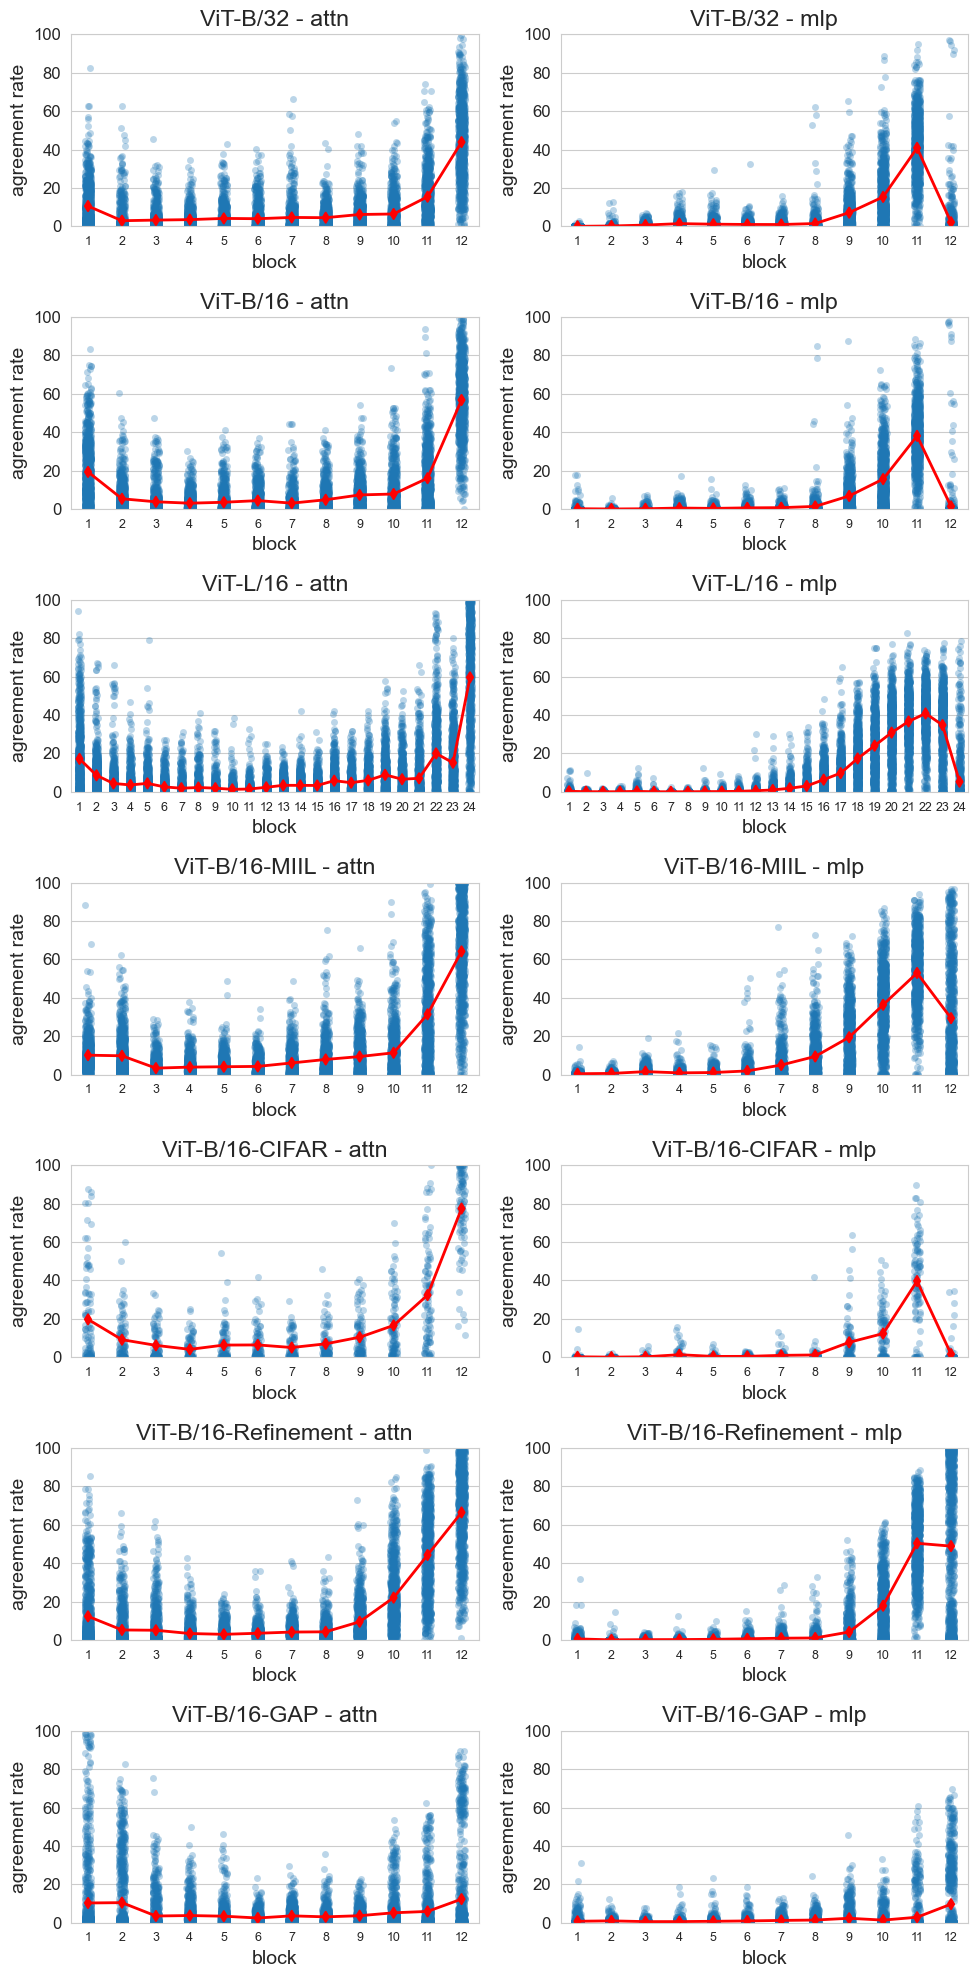

In [31]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(10, 20))
for m_idx, model_name in enumerate(MODEL_MAP.keys()):
    for l_idx, layer_type in enumerate(['attn', 'mlp']):
        df = compute_key_value_agr_rate(model_name, layer_type)
        sns.stripplot(
            df, x='block', y='agreement rate', alpha=0.3, zorder=1,
            ax=axes[m_idx, l_idx]
        )
        sns.pointplot(
            df, x='block', y='agreement rate', color='red',
            markers="d", scale=.75, errorbar=None, ax=axes[m_idx, l_idx]
        )
        axes[m_idx, l_idx].set_title(f'{MODEL_MAP[model_name]} - {layer_type}')
        axes[m_idx, l_idx].set_ylim((0,100))
        
        axes[m_idx, l_idx].xaxis.set_tick_params(labelsize=9)
        axes[m_idx, l_idx].yaxis.set_tick_params(labelsize=12)

plt.tight_layout()
f = RES_PATH / 'figures' / f'key_val_agr.png'
plt.savefig(f, dpi=300)
plt.show()

#### Compare all

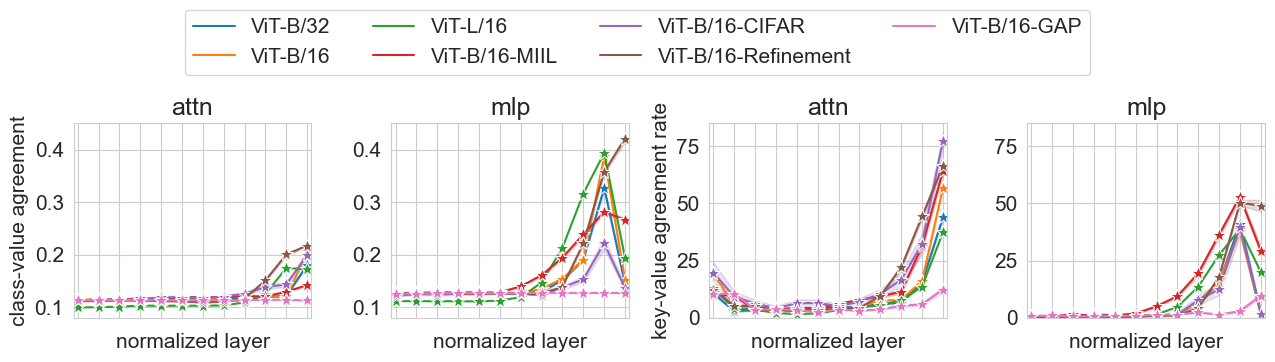

In [26]:
plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(13, 3))
for layer_type, ax in zip(['attn', 'mlp'], axes.flat[:2]):
    dfs = []
    random_k = []
    for model_name in MODEL_MAP.keys():
        mem = Memory(PROJ_PATH, DATASET_PATH, model_name)
        df, _, rk = mem.compute_class_value_agr(layer_type)
        random_k.append(rk)
    
        if model_name == 'vit_large_16':
            new_df = []
            for idx, b in enumerate(np.arange(1, 25, 2)):
                mean = df.loc[df['block'].isin([b, b+1])]['top-1 logits'].mean()
                new_df.append([mean, idx+1, MODEL_MAP['vit_large_16']])
            new_df = pd.DataFrame(
                new_df, columns=['top-1 logits', 'block', 'model']
            )
            df = new_df
        else:
            df['model'] = MODEL_MAP[model_name]
        
        dfs.append(df)

    dfs = pd.concat(dfs)
    sns.lineplot(
        dfs, x='block', y='top-1 logits', hue='model', ax=ax,
        marker='*', markersize=10
    )
    ax.set_title(layer_type)
    ax.set_ylim((0.08, 0.45))
    ax.set_xticks(np.arange(1, 13))
    ax.set_xticklabels([])
    ax.set_xlim((0.8, 12.2))
    ax.set_xlabel('normalized layer')

axes[0].set_ylabel('class-value agreement')
axes[1].set_ylabel('')


for layer_type, ax in zip(['attn', 'mlp'], axes[2:].flat):
    dfs = []
    for model_name in MODEL_MAP.keys():
        df = compute_key_value_agr_rate(model_name, layer_type)
    
        if model_name == 'vit_large_16':
            new_df = []
            for idx, b in enumerate(np.arange(1, 25, 2)):
                mean = df.loc[df['block'].isin([b, b+1])]['agreement rate'].mean()
                new_df.append([mean, idx+1, MODEL_MAP['vit_large_16']])
            new_df = pd.DataFrame(
                new_df, columns=['agreement rate', 'block', 'model']
            )
            df = new_df
        else:
            df['model'] = MODEL_MAP[model_name]
        
        dfs.append(df)

    dfs = pd.concat(dfs)
    sns.lineplot(
        dfs, x='block', y='agreement rate', hue='model', ax=ax,
        marker='*', markersize=10
    )
    ax.set_title(layer_type)
    ax.set_ylim((0,85))
    ax.set_xticks(np.arange(1, 13))
    ax.set_xticklabels([])
    ax.set_xlim((0.8, 12.2))
    ax.set_xlabel('normalized layer')

axes[2].set_ylabel('key-value agreement rate')
axes[3].set_ylabel('')

lines, labels = axes[1].get_legend_handles_labels()
lgd = fig.legend(
    lines, labels, loc='upper center', ncol=4,
    bbox_to_anchor=(0.5, 1.25),
)

for ax in axes.flat:
    ax.get_legend().remove()

plt.tight_layout()
f = RES_PATH / 'figures' / f'compare_all.png'
plt.savefig(f, dpi=300, bbox_inches='tight')
plt.show()

### Agreement rate influence in accuracy

We further evaluated the influence of these findings on the accuracy of the model, and compared the agreement rate of correctly classified vs. misclassified samples. 

In [27]:
def compute_agr_rate_diff(model_name, layer_type, n_perm=300):
    """
    Compute difference in key-value agreement rate between accurate and non-accurate samples.
    """
    if 'large' in model_name:
        n_layers = 24
    else:
        n_layers = 12
    
    # Get accuracy
    acc_file = PROJ_PATH / 'results/class_embed'/ model_name / 'acc.pt'
    acc = torch.load(acc_file, map_location=device)
    
    print(f'CLS agreement rate for {layer_type} layer:')
    for b in range(n_layers):
        # Get difference in accuracy
        print(f'Block {b+1}')
        f = RES_PATH / 'memories/' / model_name / f'{layer_type}_{b}_value-class_agreement.pt'
        agr = torch.load(f, map_location='cpu')[:,:, 0].flatten()

        acc_1 = agr[acc==1].float()
        agr_acc = torch.sum(acc_1) / acc_1.shape[0] * 100
    
        acc_2 = agr[acc==0].float()
        agr_inacc = torch.sum(acc_2) / acc_2.shape[0] * 100
        print(f'accurate samples: {agr_acc}')
        print(f'inaccurate samples: {agr_inacc}')
        
        # Compare to random model
        true_diff = agr_acc - agr_inacc
        
        random_diffs = []
        for p in range(n_perm):
            rand_idxs = torch.randperm(len(acc))
            r_acc_1 = agr[rand_idxs[:len(acc_1)]].float()
            r_agr_acc = torch.sum(r_acc_1) / r_acc_1.shape[0] * 100
    
            r_acc_2 = agr[rand_idxs[len(acc_1):]].float()
            r_agr_inacc = torch.sum(r_acc_2) / r_acc_2.shape[0] * 100
            
            random_diffs.append(r_agr_acc - r_agr_inacc)
        pval = torch.sum(true_diff < torch.stack(random_diffs)) / n_perm
        
        print(f'pval: {pval}')
        print('\n')
    return

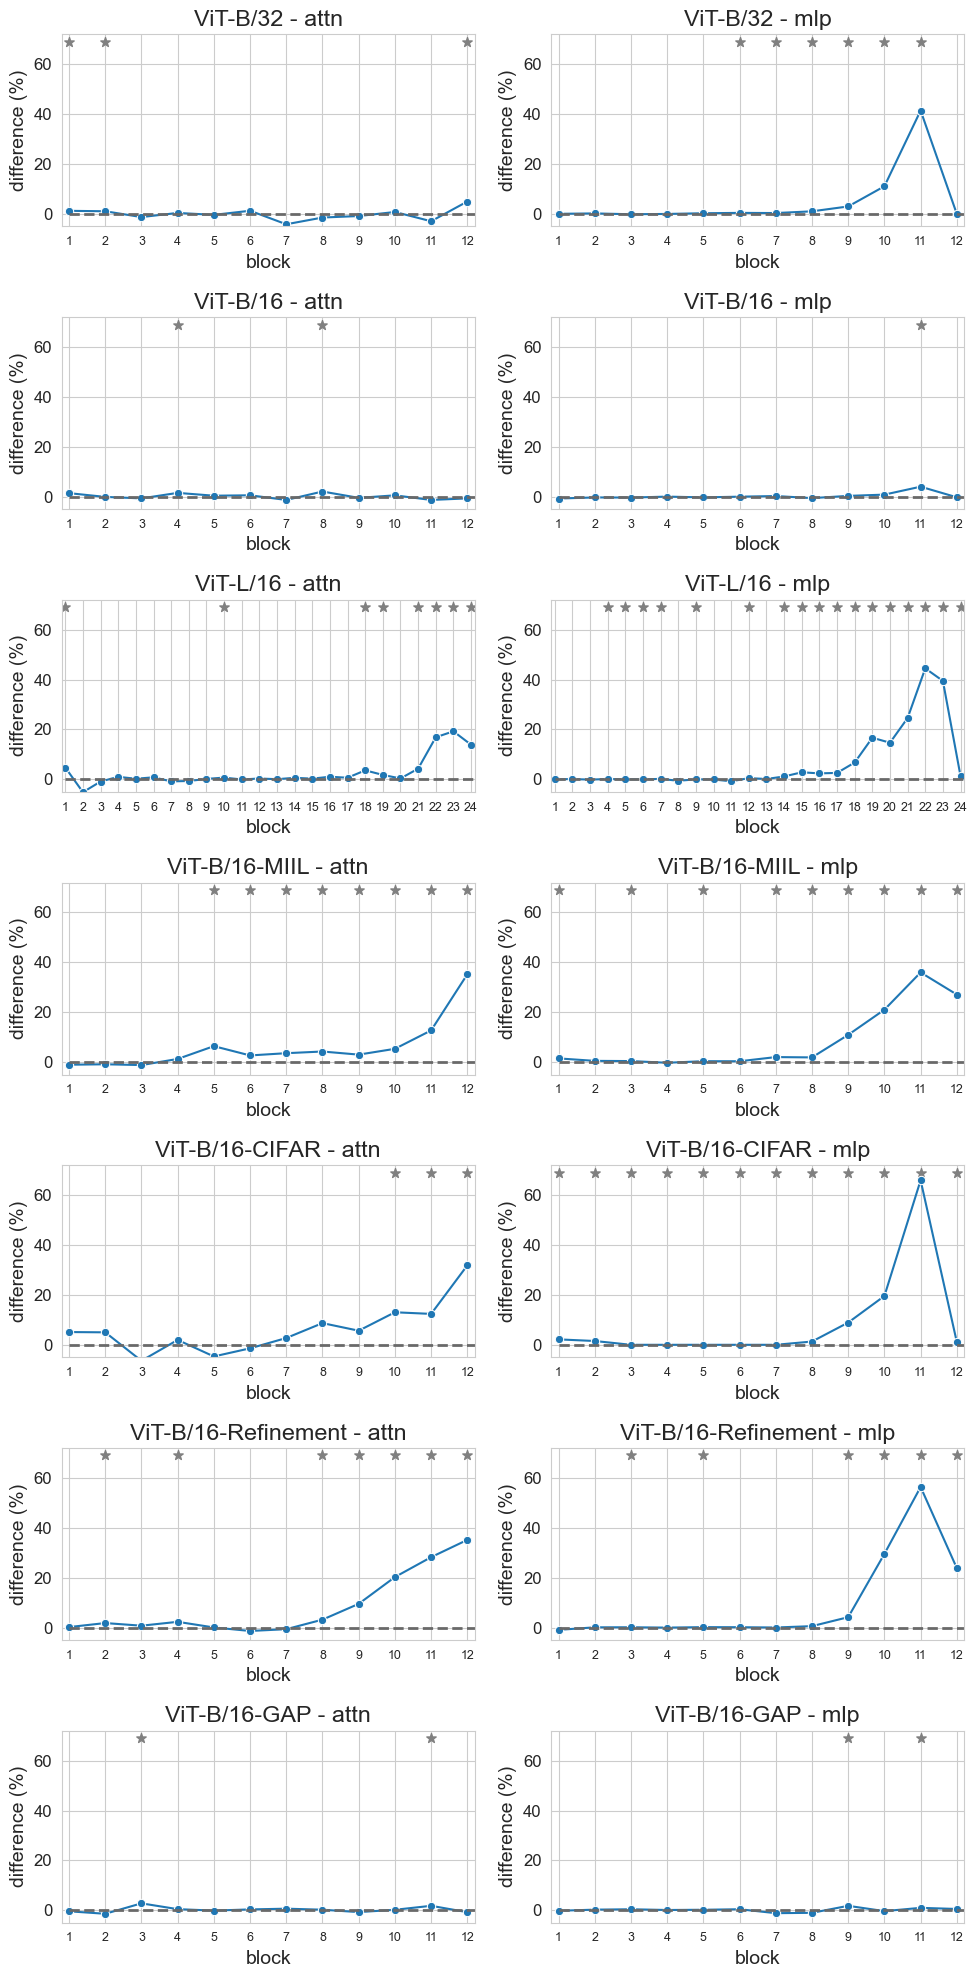

In [33]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(10,20))
for m_idx, model_name in enumerate(MODEL_MAP.keys()):
    for l_idx, layer_type in enumerate(['attn', 'mlp']):
        if 'large' in model_name:
            n_layers = 24
        else:
            n_layers = 12
        
        # Get accuracy
        acc_file = PROJ_PATH / 'results/class_embed'/ model_name / 'acc.pt'
        acc = torch.load(acc_file, map_location=device)
        
        diffs = []
        pvals = []
        for b in range(n_layers):
            # Compute difference in accuracy
            f = RES_PATH / 'memories/' / model_name / f'{layer_type}_{b}_value-class_agreement.pt'
            agr = torch.load(f, map_location='cpu')[:,:, 0].flatten()
        
            acc_1 = agr[acc==1].float()
            agr_acc = torch.sum(acc_1) / acc_1.shape[0] * 100
            acc_2 = agr[acc==0].float()
            agr_inacc = torch.sum(acc_2) / acc_2.shape[0] * 100
        
            true_diff = agr_acc - agr_inacc
            diffs.append(true_diff.detach().numpy())
            
            # Compare to random model
            random_diffs = []
            for p in range(300):
                rand_idxs = torch.randperm(len(acc))
                r_acc_1 = agr[rand_idxs[:len(acc_1)]].float()
                r_agr_acc = torch.sum(r_acc_1) / r_acc_1.shape[0] * 100
                r_acc_2 = agr[rand_idxs[len(acc_1):]].float()
                r_agr_inacc = torch.sum(r_acc_2) / r_acc_2.shape[0] * 100
                
                random_diffs.append(r_agr_acc - r_agr_inacc)
        
            pval = torch.sum(true_diff < torch.stack(random_diffs)) / 300
            pvals.append(pval.detach().numpy())
        
        df = pd.DataFrame({'diff': diffs, 'block': np.arange(1, n_layers+1)})
        df['model'] = model_name
        df['layer'] = layer_type
        df['diff'] = df['diff'].astype('float')
    
        # Plot pvalues
        sig = np.where(np.array(pvals) < 0.05)[0] + 1
        axes[m_idx, l_idx].scatter(sig, [69] * len(sig), marker='*', c='grey', s=50)
        
        sns.lineplot(df, x='block', y='diff', marker='o', ax=axes[m_idx, l_idx])
        axes[m_idx, l_idx].set_ylim(-5, 72)
        axes[m_idx, l_idx].set_xticks(np.arange(1, n_layers+1))
        axes[m_idx, l_idx].set_xlim((0.8, n_layers + 0.2))
    
        axes[m_idx, l_idx].hlines(
            xmin=1, xmax=n_layers+1, y=0, colors='dimgray', linestyles='--',  lw=2
        )

        axes[m_idx, l_idx].set_ylabel('difference (%)')
        axes[m_idx, l_idx].xaxis.set_tick_params(labelsize=9)
        axes[m_idx, l_idx].yaxis.set_tick_params(labelsize=12)

        axes[m_idx, l_idx].set_title(f'{MODEL_MAP[model_name]} - {layer_type}')

plt.tight_layout()
f = RES_PATH / 'figures' / f'acc_agr_rate.png'
plt.savefig(f, dpi=300)
plt.show()

## Compositionality of key-value memory pair mechanisms

The final output of a layer may combine the prediction of many key-value memory pairs, and predict a categorical distribution that is different from that of its most activating memories. 

We measure the compositionality of a layer's prediction by quantifying the number of instances where the layer's final predictions match any of the predictions of the top-5 most activated memories for that instance.

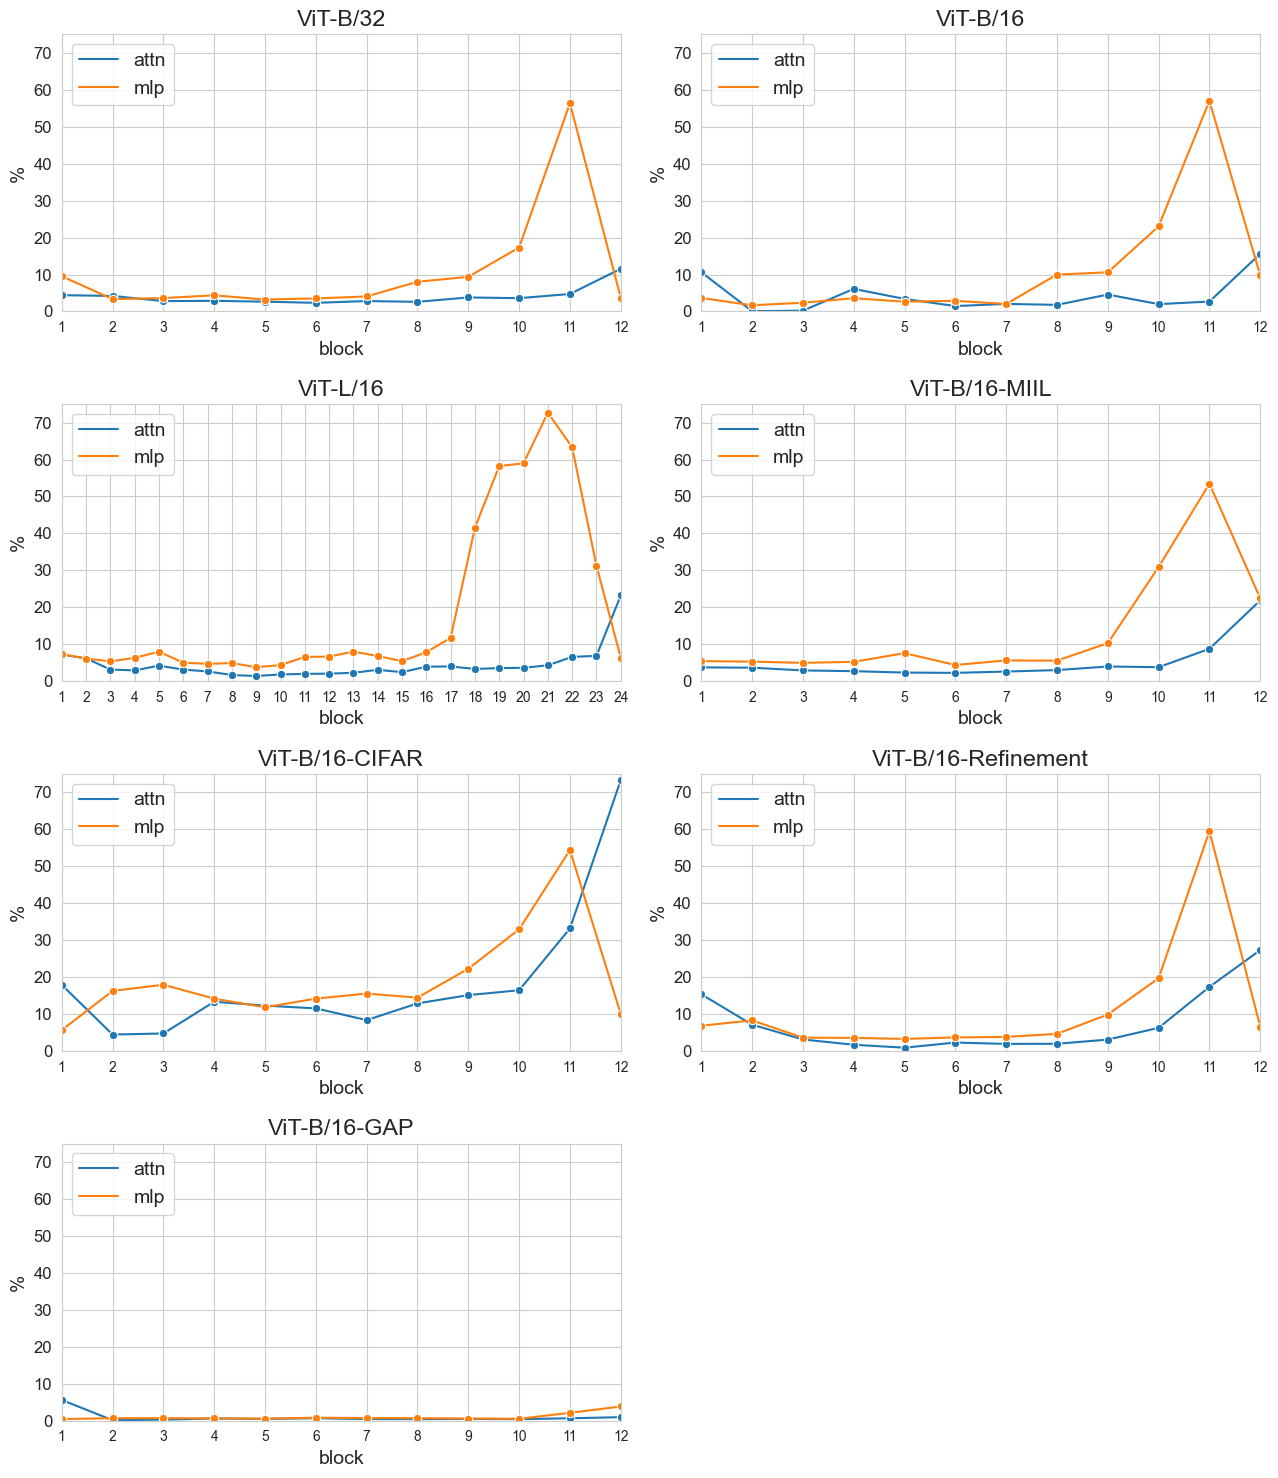

In [29]:
plt.rcParams.update({'font.size': 14})
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(13, 15))
for model_name, ax in zip(MODEL_MAP.keys(), axes.flat):
    if 'large' in model_name:
        n_layers = 24
    else:
        n_layers = 12
        
    comps = []
    for layer_type in ['attn', 'mlp']:
        for b in range(n_layers):
            f = RES_PATH / 'memories' / model_name / f'{layer_type}_{b}_top5_pred-match.pt'
            comp = torch.load(f, map_location='cpu')#[:, :, 0]
            preds = torch.any(comp, dim=-1)
            per = torch.sum(torch.any(comp, dim=-1)) / preds.flatten().shape[0] * 100
            comps.append([(b+1), layer_type, per.detach().numpy()])
    
    comps = pd.DataFrame(comps, columns=['block', 'layer type', 'percentage'])
    comps['percentage'] = comps['percentage'].astype('float')
    
    sns.lineplot(comps, x='block', y='percentage', hue='layer type', marker='o', ax=ax)
    ax.set_xticks(np.arange(1, n_layers+1))
    ax.xaxis.set_tick_params(labelsize=10)
    ax.set_xlim(1, n_layers)
    ax.set_yticks(np.arange(0, 75, 10))
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_ylim((0, 75))
    ax.set_ylabel('%')
    
    ax.legend(loc='upper left')
    ax.set_title(MODEL_MAP[model_name])

fig.delaxes(axes[3,1])

plt.tight_layout()
f = RES_PATH / 'figures' / f'composition.png'
plt.savefig(f, dpi=300)
plt.show()